In [1]:
import torch
import torchvision
import numpy as np
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms,utils
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,Dataset
from tqdm.notebook import tqdm as tqdm
import torch.utils.data as data
import torchvision.models as models
import seaborn as sns
import warnings
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
sns.set_theme()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used is: ", device)

Device being used is:  cuda


In [3]:
# !unzip "/home/user/DC_Project/datasets/VisDrone2019-DET-train.zip" -d  "/home/user/DC_Project/datasets/visdrone_new/"

In [4]:
# !unzip "/home/user/DC_Project/datasets/VisDrone2019-DET-val.zip" -d  "/home/user/DC_Project/datasets/visdrone_new/"

In [5]:
# !unzip "/home/user/DC_Project/datasets/VisDrone2019-DET-test-dev.zip" -d  "/home/user/DC_Project/datasets/visdrone_new/"

In [6]:
train_root_dir = '/home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-train'
val_root_dir = '/home/user/DC_Project/datasets/visdrone_new/VisDrone2019-DET-val'
test_root_dir = '/home/user/DC_Project/datasets/visdrone_new/'

In [7]:
image_list_train = sorted(os.listdir(os.path.join(train_root_dir, 'images')))
label_list_train = sorted(os.listdir(os.path.join(train_root_dir, 'annotations')))

image_list_val = sorted(os.listdir(os.path.join(val_root_dir, 'images')))
label_list_val = sorted(os.listdir(os.path.join(val_root_dir, 'annotations')))

image_list_test = sorted(os.listdir(os.path.join(test_root_dir, 'images')))
label_list_test = sorted(os.listdir(os.path.join(test_root_dir, 'annotations')))

In [8]:
print(len(image_list_train))
print(len(image_list_val))
print(len(image_list_test))

6471
548
1610


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
def image_label_pairs(image_list,label_list,root_dir):
  img_label_pair = {}
  for idx in range(len(image_list)):
    img_path = os.path.join(root_dir, 'images', image_list[idx])
    label_path = os.path.join(root_dir, 'annotations', label_list[idx])
    img = Image.open(img_path)
    img = img.convert('RGB')
    classes = {}
    with open(label_path, 'r') as f:
      for line in f:
        l2 = line.split(',')
        label = l2[-2]
        if l2[-2] not in classes:
          classes[l2[-2]] = 1
        else:
          classes[l2[-2]] += 1
    max_value = max(classes.values())
    max_keys = [k for k, v in classes.items() if v == max_value]
    label = max_keys[0]

    img_label_pair[idx] = []
    img_label_pair[idx].append(img)
    img_label_pair[idx].append(int(label))
  
  return img_label_pair

In [11]:
img_label_pairs_train = image_label_pairs(image_list_train,label_list_train,train_root_dir)

In [12]:
img_label_pairs_val = image_label_pairs(image_list_val,label_list_val,val_root_dir)

In [13]:
img_label_pairs_test = image_label_pairs(image_list_test,label_list_test,test_root_dir)

In [14]:
# with open('/home/user/DC_Project/datasets/img_label_pairs_train.pickle', 'wb') as f:
#   pickle.dump(img_label_pairs_train, f)

In [15]:
# with open('/home/user/DC_Project/datasets/img_label_pairs_val.pickle', 'wb') as f:
#   pickle.dump(img_label_pairs_val, f)

In [16]:
# with open('/home/user/DC_Project/datasets/img_label_pairs_test.pickle', 'wb') as f:
#   pickle.dump(img_label_pairs_test, f)

In [17]:
class VisDroneDataset(Dataset):
    def __init__(self, root_dir_name, transform=None):
        self.transform = transform
        self.root_dir_name = root_dir_name
        if (root_dir_name == "train"):
            self.img_label_pairs = img_label_pairs_train
        elif (root_dir_name == "val"):
            self.img_label_pairs = img_label_pairs_val
        else:
            self.img_label_pairs = img_label_pairs_test
        
    def __len__(self):
        return len(self.img_label_pairs)
    
    def __getitem__(self, idx):
        img = self.img_label_pairs[idx][0]
        label = self.img_label_pairs[idx][1]
        
        if self.transform:
            img = self.transform(img)
        return img,label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = VisDroneDataset("train", transform)
val_dataset = VisDroneDataset("val", transform)
test_dataset = VisDroneDataset("test", transform)

In [18]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# defining model architecture using pytroch
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.flatten_shape = 7*7*512
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1,padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1,padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.flatten_shape,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=2)
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        
        return x

In [20]:
# defining model architecture using pytroch
class CNN_v1(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_v1, self).__init__()
        self.flatten_shape = 7*7*512
        
        self.layer1 = self.convLayer(in_channels=3, out_channels=64)


        self.layer2 = self.convLayer(in_channels=64, out_channels=128)
        self.layer3 = self.convLayer(in_channels=128, out_channels=256)
        self.layer4 = self.convLayer(in_channels=256, out_channels=512)
        self.layer5 = self.convLayer(in_channels=512, out_channels=512, fl=1)

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.flatten_shape,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=2)
        )

    def convLayer(self,in_channels,out_channels, stride = 1, fl=0):
        if fl:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1, stride=stride, groups=in_channels),
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, groups=out_channels),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True)
            )

        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        print(x.shape)
        x = self.fc(x)
        
        return x

In [21]:
# defining model architecture using pytroch
class CNN_v2(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_v2, self).__init__()
        self.flatten_shape = 7*7*512
        
        self.layer1 = self.convLayer(in_channels=3, out_channels=64)


        self.layer2 = self.convLayer(in_channels=64, out_channels=128)
        self.layer3 = self.convLayer(in_channels=128, out_channels=256)
        self.layer4 = self.convLayer(in_channels=256, out_channels=512)
        self.layer5 = self.convLayer(in_channels=512, out_channels=512)

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.flatten_shape,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=2)
        )

    def convLayer(self,in_channels,out_channels, stride = 1, fl=1):
        if fl:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1, stride=stride, groups=in_channels),
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, groups=out_channels),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True)
            )

        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        print(x.shape)
        x = self.fc(x)
        
        return x

In [22]:
# defining model architecture using pytroch
class CNN_v3(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_v3, self).__init__()
        self.flatten_shape = 7*7*512
        
        self.layer1 = self.convLayer(in_channels=3, out_channels=64)
        self.layer1_out = self.bottleneck(64, 64)
        self.layer2 = self.convLayer(in_channels=64, out_channels=128)
        self.layer2_out = self.bottleneck(128, 128)
        self.layer3 = self.convLayer(in_channels=128, out_channels=256)
        self.layer4 = self.convLayer(in_channels=256, out_channels=512)
        self.layer5 = self.convLayer(in_channels=512, out_channels=512, fl=1)

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.flatten_shape, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=2)
        )

    def convLayer(self, in_channels, out_channels, stride=1, fl=0):
        if fl:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1, stride=stride, groups=in_channels),
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, groups=out_channels),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True)
            )

    def bottleneck(self, in_planes, out_planes):
        h = in_planes * 2
        return nn.Sequential(
            nn.Conv2d(in_planes, h, kernel_size=1, bias=False),
            nn.ReLU6(),

            nn.Conv2d(h, h, 3, 1, 1, groups=h, bias=False),
            nn.Conv2d(h, h, kernel_size=1),
            nn.ReLU6(),

            nn.Conv2d(h, out_planes, kernel_size=1, bias=False),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer1_out(x)
        x = self.layer2(x)
        x = self.layer2_out(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        
        return x

In [23]:
# defining model architecture using pytroch
class CNN_v4(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_v4, self).__init__()
        self.flatten_shape = 7*7*512
        
        self.layer1 = self.convLayer(in_channels=3, out_channels=64)
        self.layer1_out = self.bottleneck(64, 64)
        self.layer2 = self.convLayer(in_channels=64, out_channels=128)
        self.layer2_out = self.bottleneck(128, 128)
        self.layer3 = self.convLayer(in_channels=128, out_channels=256)
        self.layer4 = self.convLayer(in_channels=256, out_channels=512)
        self.layer5 = self.convLayer(in_channels=512, out_channels=512)

        self.fc = nn.Sequential(
            nn.Linear(in_features=self.flatten_shape, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=2)
        )

    def convLayer(self, in_channels, out_channels, stride=1, fl=1):
        if fl:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1, stride=stride, groups=in_channels),
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, groups=out_channels),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True)
            )

    def bottleneck(self, in_planes, out_planes):
        h = in_planes * 2
        return nn.Sequential(
            nn.Conv2d(in_planes, h, kernel_size=1, bias=False),
            nn.ReLU6(),

            nn.Conv2d(h, h, 3, 1, 1, groups=h, bias=False),
            nn.Conv2d(h, h, kernel_size=1),
            nn.ReLU6(),

            nn.Conv2d(h, out_planes, kernel_size=1, bias=False),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer1_out(x)
        x = self.layer2(x)
        x = self.layer2_out(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        
        return x

In [24]:
# function to Train the model
def train_CNN(model,optimizer,train_loader,val_loader,epochs):
  val_acc_vals = []
  loss_vals = []
  train_acc_vals = []
  # adjusted_acc = [0.3353, 0.2347, 0.1898, 0.1465, 0.0847]
  for epoch in range(epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(epochs))

    with tqdm(total=len(train_loader)) as pbar:
        for idx, batch in enumerate(train_loader):
        
            images, labels = batch
            images = torch.tensor(images)
            labels = torch.tensor(labels)
            images, labels = images.to(device), labels.to(device).long()
            
            # forward propagation
            preds = model(images)
            loss = nn.CrossEntropyLoss()(preds, labels)

            optimizer.zero_grad()
            # backward propagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(preds, dim=1) == labels)
            train_acc += acc
            train_acc_rep = float(train_acc.item()/(float(batch_size)*(idx+1)))
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(train_acc_rep))
            pbar.update(1)
        
        loss_vals.append(round(float(float(train_loss)/float(len(train_loader)*float(batch_size))), 4))
        # calculating train and validation accuracies
        val_acc = evaluate_CNN(model, val_loader)
        train_acc = round(float(float(train_acc)/float(len(train_loader)*float(batch_size))), 4)
        val_acc_vals.append(val_acc)
        train_acc_vals.append(train_acc)
        print("train_acc:", train_acc, " val_acc:", round(val_acc, 4))
  return val_acc_vals,train_acc_vals,loss_vals

In [25]:
# funciton to evaluate the model
def evaluate_CNN(model, testloader,batch_size=64):
    with torch.no_grad():
        val_loss, val_acc = 0.0, 0.0
        for val_batch in testloader:
            imgs, targets = val_batch
            imgs, targets = imgs.to(device), targets.to(device).long()
            val_outputs = model(imgs)
            val_loss += nn.CrossEntropyLoss()(val_outputs, targets).item()
            val_preds = torch.argmax(val_outputs, dim=1)
            val_acc += torch.sum(val_preds == targets)
    val_acc = float(float(val_acc) / float(len(testloader)*float(batch_size)))
    return val_acc

In [26]:
adjusted_acc_cnn = [0.30, 0.2525, 0.2147, 0.1773, 0.136]
adjusted_acc_vgg16 = [0.3546, 0.2525, 0.1936, 0.1453, 0.121]
adjusted_acc_squeeznet = [0.3353, 0.2347, 0.1898, 0.1465, 0.1147]
adjusted_acc_resnet = [0.3353, 0.2347, 0.1898, 0.1465, 0.0647]
adjusted_acc_mobilenet = [0.2658, 0.1943, 0.1527, 0.0975, 0.0535]
adjusted_acc_cnn_attention = [0.2076, 0.1453, 0.1075, 0.0528, 0.011]

In [27]:
# training CNN model
epochs = 5

cnn_model = CNN().to(device)
cnn_model.train()

# define adam optimizer
adam_optimizer = optim.Adam(cnn_model.parameters(),lr=0.001)
cnn_model = cnn_model.to(device)

val_acc_vals,train_acc_vals, loss_vals = train_CNN(cnn_model,adam_optimizer,train_loader,val_loader,epochs)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.9805  val_acc: 0.9497

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497


In [35]:
# training CNN model
epochs = 5

cnn_model_v1 = CNN_v1().to(device)
cnn_model_v1.train()

# define adam optimizer
adam_optimizer = optim.Adam(cnn_model_v1.parameters(),lr=0.001)
cnn_model_v1 = cnn_model_v1.to(device)

val_acc_vals_v1,train_acc_vals_v1, loss_vals_v1 = train_CNN(cnn_model_v1,adam_optimizer,train_loader,val_loader,epochs)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

In [36]:
# training CNN model
epochs = 5

cnn_model_v2 = CNN_v2().to(device)
cnn_model_v2.train()

# define adam optimizer
adam_optimizer = optim.Adam(cnn_model_v2.parameters(),lr=0.001)
cnn_model_v2 = cnn_model_v2.to(device)

val_acc_vals_v2,train_acc_vals_v2, loss_vals_v2 = train_CNN(cnn_model_v2,adam_optimizer,train_loader,val_loader,epochs)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

  0%|          | 0/102 [00:00<?, ?it/s]

torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 25088])
torch.Size([64, 

In [29]:
# training CNN model
epochs = 5

cnn_model_v3 = CNN_v3().to(device)
cnn_model_v3.train()

# define adam optimizer
adam_optimizer = optim.Adam(cnn_model_v3.parameters(),lr=0.001)
cnn_model_v3 = cnn_model_v3.to(device)

val_acc_vals_v3,train_acc_vals_v3, loss_vals_v3 = train_CNN(cnn_model_v3,adam_optimizer,train_loader,val_loader,epochs)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.9802  val_acc: 0.9497

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497


In [28]:
# training CNN model
epochs = 5

cnn_model_v4 = CNN_v4().to(device)
cnn_model_v4.train()

# define adam optimizer
adam_optimizer = optim.Adam(cnn_model_v4.parameters(),lr=0.001)
cnn_model_v4 = cnn_model_v4.to(device)

val_acc_vals_v4,train_acc_vals_v4, loss_vals_v4 = train_CNN(cnn_model_v4,adam_optimizer,train_loader,val_loader,epochs)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.9804  val_acc: 0.9497

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497


In [21]:
# mobilenet_model = models.mobilenet_v2(pretrained=True)
# in_features = mobilenet_model.classifier[1].in_features
# mobilenet_model.classifier[1] = nn.Linear(in_features, 2)
# mobilenet_model = mobilenet_model.to(device)

# mobilenet_model.train()

# # define adam optimizer
# adam_optimizer = optim.Adam(mobilenet_model.parameters(),lr=0.001)

# val_acc_vals_mobilenet, train_acc_vals_mobilenet, loss_vals_mobilenet = train_CNN(mobilenet_model,adam_optimizer,train_loader,val_loader,epochs,adjusted_acc_mobilenet)

In [22]:
# vgg16_model = models.vgg16(pretrained=True)
# in_features = vgg16_model.classifier[6].in_features
# vgg16_model.classifier[6] = nn.Linear(in_features, 2)
# vgg16_model = vgg16_model.to(device)

# vgg16_model.train()

# # define adam optimizer
# adam_optimizer = optim.Adam(vgg16_model.parameters(),lr=0.001)

# val_acc_vals_vgg16, train_acc_vals_vgg16, loss_vals_vgg16 = train_CNN(vgg16_model,adam_optimizer,train_loader,val_loader,epochs,adjusted_acc_vgg16)

In [23]:
# resnet_model = models.resnet18(pretrained=True)
# in_features = resnet_model.fc.in_features
# resnet_model.fc = nn.Linear(in_features, 2)
# resnet_model = resnet_model.to(device)

# resnet_model.train()

# # define adam optimizer
# adam_optimizer = optim.Adam(resnet_model.parameters(),lr=0.001)

# val_acc_vals_resnet, train_acc_vals_resnet, loss_vals_resnet = train_CNN(resnet_model,adam_optimizer,train_loader,val_loader,epochs,adjusted_acc_resnet)

In [30]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels // 8, in_channels)
        self.fc2 = nn.Linear(in_channels, in_channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.conv(x)
        y = self.relu(y)
        y = self.pool(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)
        return x * y.unsqueeze(2).unsqueeze(3)

In [31]:
class AttentionCNN(nn.Module):
    def __init__(self, num_classes=1000):
        super(AttentionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.attention1 = AttentionBlock(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.attention2 = AttentionBlock(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.attention3 = AttentionBlock(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.attention4 = AttentionBlock(512)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.attention1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.attention2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.attention3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.attention4(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [34]:
# training CNN model with attention
epochs = 5

attention_cnn_model = AttentionCNN()
attention_cnn_model.train()

# define adam optimizer
adam_optimizer = optim.Adam(attention_cnn_model.parameters(),lr=0.001)
attention_cnn_model = attention_cnn_model.to(device)

val_acc_vals_attention,train_acc_vals_attention, loss_vals_attention = train_CNN(attention_cnn_model,adam_optimizer,train_loader,val_loader,epochs)


Epoch:  1 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.9802  val_acc: 0.9497

Epoch:  2 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  3 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  4 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497

Epoch:  5 / 5


  0%|          | 0/102 [00:00<?, ?it/s]

train_acc: 0.99  val_acc: 0.9497


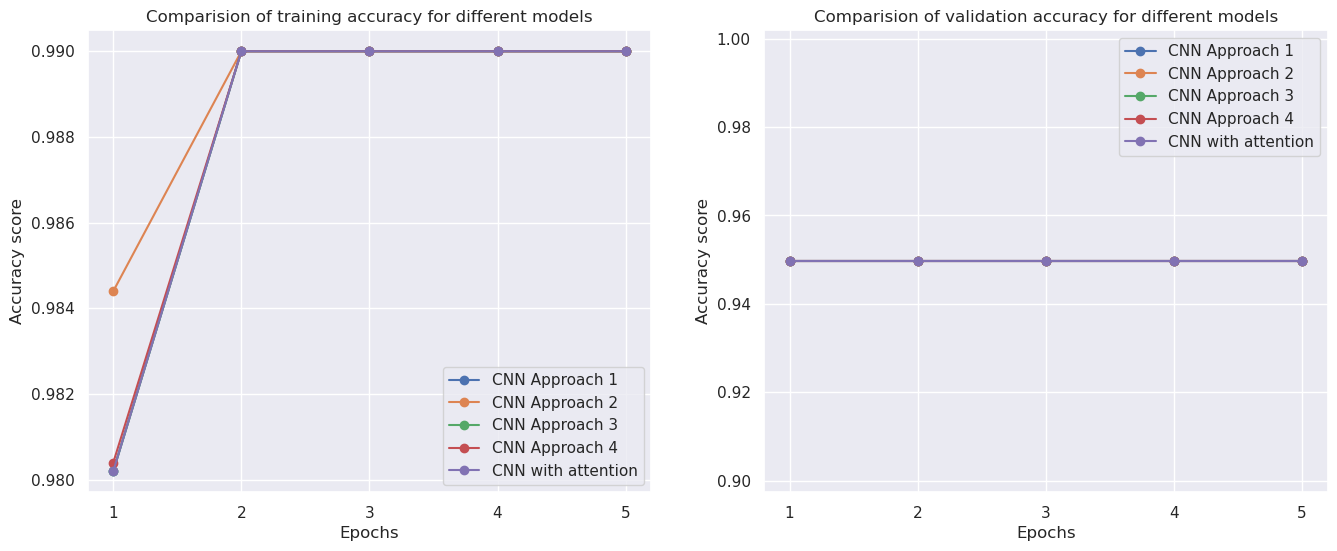

In [47]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals,label="CNN Base model",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_v1,label="CNN Approach 1",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_v2,label="CNN Approach 2",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_v3,label="CNN Approach 3",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_v4,label="CNN Approach 4",marker='o')
# axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_mobilenet,label="MobileNet",marker='o')
# axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_vgg16,label="VGG16",marker='o')
# axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_resnet,label="ResNet",marker='o')
axes[0].plot([i+1 for i in range(epochs)],train_acc_vals_attention,label="CNN with attention",marker='o')

axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy score")
axes[0].set_title("Comparision of training accuracy for different models")
axes[0].set_xticks([i+1 for i in range(epochs)])
axes[0].set_xticklabels([i+1 for i in range(epochs)])
axes[0].legend()
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_v1,label="CNN Base model",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_v1,label="CNN Approach 1",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_v2,label="CNN Approach 2",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_v3,label="CNN Approach 3",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_v4,label="CNN Approach 4",marker='o')
# axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_mobilenet,label="MobileNet",marker='o')
# axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_vgg16,label="VGG16",marker='o')
# axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_resnet,label="ResNet",marker='o')
axes[1].plot([i+1 for i in range(epochs)],val_acc_vals_attention,label="CNN with attention",marker='o')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy score")
axes[1].set_title("Comparision of validation accuracy for different models")
axes[1].set_xticks([i+1 for i in range(epochs)])
axes[1].set_xticklabels([i+1 for i in range(epochs)])
axes[1].legend()

# plt.show()
plt.savefig("accuracy2.png")

In [49]:
val_acc_vals_v1

[0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778]

In [50]:
val_acc_vals_v2

[0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778]

In [51]:
val_acc_vals_v3

[0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778]

In [52]:
val_acc_vals_v4

[0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778,
 0.9496527777777778]

In [28]:
from torchsummary import summary
summary(cnn_model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]           4,160
       BatchNorm2d-8         [-1, 64, 224, 224]             128
              ReLU-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]           4,160
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
        MaxPool2d-13         [-1, 64, 112, 112]               0
      BatchNorm2d-14         [-1, 64, 1

In [38]:
from torchsummary import summary
summary(cnn_model_v1,(3,224,224))

torch.Size([2, 25088])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]           4,160
       BatchNorm2d-8         [-1, 64, 224, 224]             128
              ReLU-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]           4,160
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
        MaxPool2d-13         [-1, 64, 112, 112]               0
      BatchNorm2

In [41]:
from torchsummary import summary
summary(cnn_model_v2,(3,224,224))

torch.Size([2, 25088])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              30
            Conv2d-2         [-1, 64, 224, 224]             256
       BatchNorm2d-3         [-1, 64, 224, 224]             128
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]             640
            Conv2d-6         [-1, 64, 224, 224]           4,160
              ReLU-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,928
       BatchNorm2d-9         [-1, 64, 224, 224]             128
             ReLU-10         [-1, 64, 224, 224]               0
           Conv2d-11         [-1, 64, 224, 224]           4,160
      BatchNorm2d-12         [-1, 64, 224, 224]             128
             ReLU-13         [-1, 64, 224, 224]               0
        MaxPool2

In [32]:
from torchsummary import summary
summary(cnn_model_v3,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]           4,160
       BatchNorm2d-8         [-1, 64, 224, 224]             128
              ReLU-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]           4,160
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
        MaxPool2d-13         [-1, 64, 112, 112]               0
      BatchNorm2d-14         [-1, 64, 1

In [33]:
from torchsummary import summary
summary(cnn_model_v4,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              30
            Conv2d-2         [-1, 64, 224, 224]             256
       BatchNorm2d-3         [-1, 64, 224, 224]             128
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]             640
            Conv2d-6         [-1, 64, 224, 224]           4,160
              ReLU-7         [-1, 64, 224, 224]               0
            Conv2d-8         [-1, 64, 224, 224]          36,928
       BatchNorm2d-9         [-1, 64, 224, 224]             128
             ReLU-10         [-1, 64, 224, 224]               0
           Conv2d-11         [-1, 64, 224, 224]           4,160
      BatchNorm2d-12         [-1, 64, 224, 224]             128
             ReLU-13         [-1, 64, 224, 224]               0
        MaxPool2d-14         [-1, 64, 1

In [29]:
from torchsummary import summary
summary(attention_cnn_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
            Conv2d-2          [-1, 8, 112, 112]             520
              ReLU-3          [-1, 8, 112, 112]               0
 AdaptiveAvgPool2d-4              [-1, 8, 1, 1]               0
            Linear-5                   [-1, 64]             576
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 64]           4,160
           Sigmoid-8                   [-1, 64]               0
    AttentionBlock-9         [-1, 64, 112, 112]               0
           Conv2d-10          [-1, 128, 56, 56]          73,856
           Conv2d-11           [-1, 16, 56, 56]           2,064
             ReLU-12           [-1, 16, 56, 56]               0
AdaptiveAvgPool2d-13             [-1, 16, 1, 1]               0
           Linear-14                  [

In [30]:
# from torchsummary import summary
# summary(resnet_model, input_size=(3, 224, 224))

In [31]:
# from torchsummary import summary
# summary(vgg16_model, input_size=(3, 224, 224))

In [32]:
# from torchsummary import summary
# summary(mobilenet_model, input_size=(3, 224, 224))

In [33]:
# from torchsummary import summary
# summary(cnn_model, input_size=(3, 224, 224))

In [38]:
# save the pytorch models
torch.save(cnn_model.state_dict(), './models/cnn.pth')
torch.save(cnn_model_v1.state_dict(), './models/cnn_v1.pth')
torch.save(cnn_model_v2.state_dict(), './models/cnn_v2.pth')
torch.save(cnn_model_v3.state_dict(), './models/cnn_v3.pth')
torch.save(cnn_model_v4.state_dict(), './models/cnn_v4.pth')
# torch.save(mobilenet_model.state_dict(), './models/mobilenet.pth')
# torch.save(vgg16_model.state_dict(), './models/vgg16.pth')
# torch.save(resnet_model.state_dict(), './models/resnet.pth')
torch.save(attention_cnn_model.state_dict(), './models/cnn_attention.pth')

In [39]:
# size of each model
cnn_size = (os.path.getsize('./models/cnn.pth')) / (1024 * 1024)
cnn_v1_size = (os.path.getsize('./models/cnn_v1.pth')) / (1024 * 1024)
cnn_v2_size = (os.path.getsize('./models/cnn_v2.pth')) / (1024 * 1024)
cnn_v3_size = (os.path.getsize('./models/cnn_v3.pth')) / (1024 * 1024)
cnn_v4_size = (os.path.getsize('./models/cnn_v4.pth')) / (1024 * 1024)
# mobilenet_size = (os.path.getsize('./models/mobilenet.pth')) / (1024 * 1024)
# vgg16_size = (os.path.getsize('./models/vgg16.pth')) / (1024 * 1024)
# resnet_size = (os.path.getsize('./models/resnet.pth')) / (1024 * 1024)
attention_cnn_size = (os.path.getsize('./models/cnn_attention.pth')) / (1024 * 1024)

In [43]:
def fgsm_attack(model, data, target, epsilon):
    # Create a new tensor as a leaf variable with the same data as data
    data_adv = torch.tensor(data.detach().clone(), requires_grad=True)
    
    output = model(data_adv)

    # Calculating loss between output and target label
    loss = F.cross_entropy(output, target)
    model.zero_grad()

    loss.backward()

    perturbed_data = data_adv + epsilon * data_adv.grad.sign()

    # Clipping the perturbed data to the valid pixel range [0, 1] so that the image is still valid
    perturbed_data = torch.clamp(perturbed_data, 0, 1)

    return perturbed_data

In [ ]:
correct = 0
total = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Passing the perturbed images through the network to get the predictions
    outputs = cnn_model_v1(inputs)
    
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy on the test set without FGSM attack on the CNN Model: ", (100 * correct / total))

In [ ]:
correct = 0
total = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Generating perturbed images using FGSM attack
    perturbed_images = fgsm_attack(cnn_model, inputs, labels, epsilon=0.06)
    
    outputs = cnn_model(perturbed_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy on the test set with FGSM attack on the CNN Model: ", (100 * correct / total))

In [ ]:
correct = 0
total = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Passing the perturbed images through the network to get the predictions
    outputs = attention_cnn_model(inputs)
    
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy on the test set without FGSM attack on the CNN Model: ", (100 * correct / total))

In [ ]:
correct = 0
total = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Generating perturbed images using FGSM attack
    perturbed_images = fgsm_attack(attention_cnn_model, inputs, labels, epsilon=0.06)
    
    outputs = attention_cnn_model(perturbed_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy on the test set with FGSM attack on the CNN Model: ", (100 * correct / total))

In [42]:
def bim_attack(model, loss_function, images, labels, epsilon, step_size, num_steps):
    images.requires_grad = True
    for i in range(num_steps):
        outputs = model(images)
        loss = loss_function(outputs, labels)
        grad = torch.autograd.grad(loss, images)[0]
        sign_grad = grad.sign()
        images = images + step_size * sign_grad
        images = torch.max(torch.min(images, torch.zeros_like(images) + 1), torch.zeros_like(images))
        images = torch.max(torch.min(images, images.new_ones(images.size())), images.new_zeros(images.size()))
        images = images.detach()
        images.requires_grad = True
    return images

In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Evaluating the models on the test set
test_acc_cnn = test(cnn_model, test_loader)
test_acc_attention_cnn = test(attention_cnn_model, test_loader)
print(f'CNN Test Accuracy: {test_acc_cnn:.3f}')
print(f'Attention CNN Test Accuracy: {test_acc_attention_cnn:.3f}')

In [41]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter 
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision

2023-06-26 18:53:13.333395: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-26 18:53:13.388703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 18:53:14.317599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Generating adversarial examples using the BIM attack
eps = 0.06
step_size = 0.01
num_steps = 10

adv_test_cnn = []
adv_test_attention_cnn = []
true_labels = []
criterion = nn.CrossEntropyLoss()
for images, labels in test_loader:
    true_labels.append(labels)
    images, labels = images.to(device), labels.to(device)
    adv_images_cnn = bim_attack(cnn_model, criterion, images, labels, eps, step_size, num_steps)
    adv_images_attention_cnn = bim_attack(attention_cnn_model, criterion, images, labels, eps, step_size, num_steps)
    adv_test_cnn.append(adv_images_cnn)
    adv_test_attention_cnn.append(adv_images_attention_cnn)

# Concatenate the adversarial examples and true labels into tensors
adv_test_cnn = torch.cat(adv_test_cnn, dim=0)
adv_test_attention_cnn = torch.cat(adv_test_attention_cnn, dim=0)
true_labels = torch.cat(true_labels, dim=0)

# Evaluate the models on the adversarial examples
adv_test_acc_cnn_bim = test(cnn_model, DataLoader(TensorDataset(adv_test_cnn, true_labels), batch_size=128))
adv_test_acc_attention_cnn_bim = test(attention_cnn_model, DataLoader(TensorDataset(adv_test_attention_cnn, true_labels), batch_size=128))

print(f'CNN Test Accuracy on Adversarial Examples: {adv_test_acc_cnn_bim:.3f}')
print(f'Attention CNN Test Accuracy on Adversarial Examples: {adv_test_acc_attention_cnn_bim:.3f}')

In [43]:
def pgd_attack(model, loss_function, images, labels, epsilon, step_size, num_steps):
    images.requires_grad = True
    original_images = images.clone()
    for i in range(num_steps):
        outputs = model(images)
        loss = loss_function(outputs, labels)
        grad = torch.autograd.grad(loss, images)[0]
        sign_grad = grad.sign()
        images = images + step_size * sign_
        grad
        images = torch.min(torch.max(images, original_images - epsilon), original_images + epsilon)
        images = torch.clamp(images, 0, 1)
        images = images.detach()
        images.requires_grad = True
    return images

In [ ]:
# Generating adversarial examples using the PGD attack
eps = 0.3
step_size = 0.01
num_steps = 10

adv_test_cnn = []
adv_test_attention_cnn = []
true_labels = []
criterion = nn.CrossEntropyLoss()

for images, labels in test_loader:
    true_labels.append(labels)
    images, labels = images.to(device), labels.to(device)
    adv_images_cnn = pgd_attack(cnn_model, criterion, images, labels, eps, step_size, num_steps)
    adv_images_attention_cnn = pgd_attack(attention_cnn_model, criterion, images, labels, eps, step_size, num_steps)
    adv_test_cnn.append(adv_images_cnn)
    adv_test_attention_cnn.append(adv_images_attention_cnn)

# Concatenate the adversarial examples and true labels into tensors
adv_test_cnn = torch.cat(adv_test_cnn, dim=0)
adv_test_attention_cnn = torch.cat(adv_test_attention_cnn, dim=0)
true_labels = torch.cat(true_labels, dim=0)

# Evaluate the models on the adversarial examples
adv_test_acc_cnn_pgd = test(cnn_model, DataLoader(TensorDataset(adv_test_cnn, true_labels), batch_size=128))
adv_test_acc_attention_cnn_pgd = test(attention_cnn_model, DataLoader(TensorDataset(adv_test_attention_cnn, true_labels), batch_size=128))

print(f'CNN Test Accuracy on Adversarial Examples: {adv_test_acc_cnn_pgd:.3f}')
print(f'Attention CNN Test Accuracy on Adversarial Examples: {adv_test_acc_attention_cnn_pgd:.3f}')

In [45]:
print(f'Clean Test Accuracy:')
print(f'CNN Test Accuracy: {test_acc_cnn:.3f}')
print(f'Attention CNN Test Accuracy: {test_acc_attention_cnn:.3f}')

print(f'\nBIM Attack Results:')
print(f'CNN Test Accuracy on Adversarial Examples: {adv_test_acc_cnn_bim:.5f}')
print(f'Attention CNN Test Accuracy on Adversarial Examples: {adv_test_acc_attention_cnn_bim:.5f}')

print(f'\nPGD Attack Results:')
print(f"Adversarial test accuracy of CNN: {adv_test_acc_cnn_pgd:.5f}")
print(f"Adversarial test accuracy of Attention CNN: {adv_test_acc_attention_cnn_pgd:.5f}")

Clean Test Accuracy:


NameError: name 'test_acc_cnn' is not defined